<a href="https://colab.research.google.com/github/talkin24/jaxflax_lab/blob/main/Unet_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
from jax import lax, random, numpy as jnp

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state

import optax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt


In [12]:
class UnetConvBlock(nn.Module):
  out_dim: int

  # Conv Parameters
  kernel_size: tuple[int, int] = (3, 3)
  strides: int = 1
  padding: int = 0

  # BatchNorm Parameters
  use_running_average: bool = False
  momentum: float = 0.9
  epsilon: float = 1e-5
  dtype: jnp.dtype = jnp.float32

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=self.out_dim, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    x = nn.BatchNorm(use_running_average=self.use_running_average, momentum=self.momentum, epsilon = self.epsilon, dtype = self.dtype)(x) 
    x = nn.relu(x)
    x = nn.Conv(features=self.out_dim, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    x = nn.BatchNorm(use_running_average=self.use_running_average, momentum=self.momentum, epsilon = self.epsilon, dtype = self.dtype)(x) 
    x = nn.relu(x)
    return x


In [26]:
class DoubleConvBR(nn.Module):
  out_dim: int

  # Conv Parameters
  kernel_size: tuple[int, int] = (3, 3)
  strides: int = 1
  padding: int = 0
  
  # BatchNorm Parameters
  use_running_average: bool = False
  momentum: float = 0.9
  epsilon: float = 1e-5
  dtype: jnp.dtype = jnp.float32

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=self.out_dim, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    x = nn.BatchNorm(use_running_average=self.use_running_average, momentum=self.momentum, epsilon = self.epsilon, dtype = self.dtype)(x) 
    x = nn.relu(x)
    x = nn.Conv(features=self.out_dim, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    x = nn.BatchNorm(use_running_average=self.use_running_average, momentum=self.momentum, epsilon = self.epsilon, dtype = self.dtype)(x) 
    x = nn.relu(x)
    return x


class Down(nn.Module):
  out_dim: int
  
  # max_pool Parameters
  window_shape: tuple[int, int] = (2, 2)

  @nn.compact
  def __call__(self, x):
    x = nn.max_pool(x, window_shape=self.window_shape)
    x = DoubleConvBR(self.out_dim)(x)
    return x


class Up(nn.Module):
  out_dim: int
  
  # ConvTranspose Parameters
  kernel_size: tuple[int, int] = (2, 2)
  strides: tuple[int, int] = (2, 2)
  padding: int = 0
 
  @nn.compact
  def __call__(self, x):
    x = nn.ConvTranspose(features=self.out_dim * 2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)(x)
    x = DoubleConvBR(self.out_dim)(x)
    return x


class Unet(nn.Module):
  feature_scale: int = 4
  n_classes: int = 21
  window_shape: tuple[int, int] = (2, 2)

  @nn.compact
  def __call__(self, x):

  # Contracting path
    x = DoubleConvBR(64)(x)
    x = Down(128)(x)
    x = Down(256)(x)
    x = Down(512)(x)
    x = Down(1024)(x)

  # Expansive path
    x = Up(512)(x)
    x = Up(256)(x)
    x = Up(128)(x)
    x = Up(64)(x)
    
    x = nn.Dense(2)(x)


In [27]:
unet = Unet()
print(unet.tabulate(jax.random.PRNGKey(0), jnp.ones((3, 572, 572))))


                                  Unet Summary                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ batch_stats ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ Unet       │ float32[3… │ None       │             │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ DoubleCon… │ DoubleCon… │ float32[3… │ float32[0… │             │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ DoubleCon… │ Conv       │ float32[3… │ float32[1… │             │ bias:      │
│            │            │            │            │             │ float32[6… │
│            │            │            │            │             │ kernel:    │
│            │            │            │            │             │ float32[3… │
│            │            │

In [28]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [29]:
def custom_transform(x):
    # A couple of modifications here compared to tutorial #3 since we're using a CNN
    # Input: (28, 28) uint8 [0, 255] torch.Tensor, Output: (28, 28, 1) float32 [0, 1] np array
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    """Provides us with batches of numpy arrays and not PyTorch's tensors."""
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
train_lbls = jnp.array(train_dataset.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

100%|██████████| 9912422/9912422 [00:00<00:00, 74040185.36it/s]


Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9027177.42it/s]


Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21631087.82it/s]


Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11594965.77it/s]


Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 80717467.96it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37203837.17it/s]


Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22270676.69it/s]


Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9749502.95it/s]


Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



7


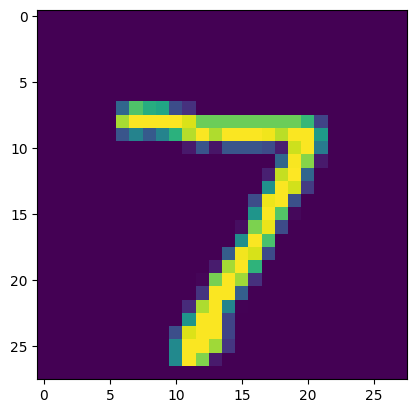

In [30]:
# Visualize a single image
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)[:, :, 0]
gt_lbl = lbls[0]

print(gt_lbl)
plt.imshow(img); plt.show()

In [35]:
@jax.jit
def train_step(state, imgs, gt_labels):
    def loss_fn(params):
        logits = Unet().apply({'params': params}, imgs)
        one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
        loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
        return loss, logits
  
    (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)  # this is the whole update now! concise!
    metrics = compute_metrics(logits=logits, gt_labels=gt_labels)  # duplicating loss calculation but it's a bit cleaner
    return state, metrics

@jax.jit
def eval_step(state, imgs, gt_labels):
    logits = Unet().apply({'params': state.params}, imgs)
    return compute_metrics(logits=logits, gt_labels=gt_labels)

In [32]:
def train_one_epoch(state, dataloader, epoch):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for cnt, (imgs, labels) in enumerate(dataloader):
        state, metrics = train_step(state, imgs, labels)
        batch_metrics.append(metrics)

    # Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

def evaluate_model(state, test_imgs, test_lbls):
    """Evaluate on the validation set."""
    metrics = eval_step(state, test_imgs, test_lbls)
    metrics = jax.device_get(metrics)  # pull from the accelerator onto host (CPU)
    metrics = jax.tree_map(lambda x: x.item(), metrics)  # np.ndarray -> scalar
    return metrics

In [37]:
# This one will keep things nice and tidy compared to our previous examples
def create_train_state(key, learning_rate, momentum):
    unet = Unet()
    params = unet.init(key, jnp.ones([1, *mnist_img_size]))['params']
    sgd_opt = optax.sgd(learning_rate, momentum)
    # TrainState is a simple built-in wrapper class that makes things a bit cleaner
    return train_state.TrainState.create(apply_fn=unet.apply, params=params, tx=sgd_opt)

def compute_metrics(*, logits, gt_labels):
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)

    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

In [38]:
# Finally let's define the high-level training/val loops
seed = 0  # needless to say these should be in a config or defined like flags
learning_rate = 0.1
momentum = 0.9
num_epochs = 2
batch_size = 32

train_state = create_train_state(jax.random.PRNGKey(seed), learning_rate, momentum)

for epoch in range(1, num_epochs + 1):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
    print(f"Train epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy'] * 100}")

    test_metrics = evaluate_model(train_state, test_images, test_lbls)
    print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")


ScopeCollectionNotFound: ignored